# POS Tagging and HMMs

In [2]:
import nltk
nltk.download('brown')
nltk.download('universal_tagset')
from nltk.corpus import brown
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pandas as pd

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


## PART 1: TRIGRAM TAGGER WITH BACKOFF

You will need to create train/dev/test splits for each domain in the brown corpus (be sure to use `tagset="universal"` when you call `brown.tagged_sents`). Afterwards, you will train a trigram tagger which backs off to a bigram tagger which backs off to a unigram tagger which finally backs off to a default tagger with `"NOUN"` (see NLTK book: Chapter 5.4 for details).

For each domain test the tagger on the dev and test data.
            
1. Which domain has the best test accuracy? Which on has the worst? Why do you think this is the case?

* `learned` (0.924234) and `belles_lettres` (0.923527) domains have the best test accuracy.

* `humor` (0.835590) and `cience_fiction` (0.859890) domains have the worst test accuracy.

* I think this is the case because there are more ambiguous contexts and unknown words in the test sets of some domains than on the other ones.

2. Which domain has the largest difference between dev and test? Why do you think this might be?

* `humor` (0.038130) and `government` (0.017866) are the domains that have the largest positive difference between dev and test.

* `science_fiction` (-0.041805) and `religion` (-0.028037) are the domains that have the largest negative difference between dev and test.

* This might be related to the variability of the sentences found in each set. In some cases, the sentences from the dev set are more similar to the train sentences. In some other cases, the test set has more similarities with the train set. The sets that have the biggest positive and negative differences are the ones that have the worst test accuracy.

In [3]:
dev_accs = []
test_accs = []
diff_accs = []
for domain in brown.categories():
    # Create train/dev/test splits
    tagged_sents = brown.tagged_sents(categories=domain, tagset="universal")
    dev_idx = int(len(tagged_sents) * .7)
    test_idx = int(len(tagged_sents) * .8)
    train = tagged_sents[:dev_idx]
    dev = tagged_sents[dev_idx:test_idx]
    test = tagged_sents[test_idx:]

    # train the Ngram taggers
    t0 = nltk.DefaultTagger('NOUN')
    t1 = nltk.UnigramTagger(train, backoff=t0)
    t2 = nltk.BigramTagger(train, backoff=t1)
    t3 = nltk.TrigramTagger(train, backoff=t2)

    # get the dev and test accuracy and their difference
    dev_acc = t3.evaluate(dev)
    test_acc = t3.evaluate(test)
    dev_accs.append(dev_acc)
    test_accs.append(test_acc)
    diff_accs.append(dev_acc - test_acc)

    # print out the domain/dev acc/test acc/ and difference
    print("Domain: ", domain)
    print("Dev Acc: ", dev_acc)
    print("Test Acc: ", test_acc)
    print("Diff Acc: ", dev_acc - test_acc)
    print()

Domain:  adventure
Dev Acc:  0.9113470640910836
Test Acc:  0.9019279128248114
Diff Acc:  0.00941915126627213

Domain:  belles_lettres
Dev Acc:  0.9271627073061407
Test Acc:  0.9235269426517656
Diff Acc:  0.0036357646543750954

Domain:  editorial
Dev Acc:  0.8966241560390098
Test Acc:  0.8979980208571211
Diff Acc:  -0.0013738648181113033

Domain:  fiction
Dev Acc:  0.9060704859493868
Test Acc:  0.9108723958333333
Diff Acc:  -0.004801909883946576

Domain:  government
Dev Acc:  0.9251101321585903
Test Acc:  0.9072439400308253
Diff Acc:  0.017866192127764968

Domain:  hobbies
Dev Acc:  0.8869329722410291
Test Acc:  0.9008226161510833
Diff Acc:  -0.013889643910054206

Domain:  humor
Dev Acc:  0.8737201365187713
Test Acc:  0.8355899419729207
Diff Acc:  0.03813019454585065

Domain:  learned
Dev Acc:  0.9143000753958281
Test Acc:  0.9242341022824362
Diff Acc:  -0.00993402688660805

Domain:  lore
Dev Acc:  0.9038090867370353
Test Acc:  0.9144726083401472
Diff Acc:  -0.010663521603111903

Domain

In [4]:
data = {"Domain": brown.categories(), "Dev Acc": dev_accs, "Test Acc": test_accs, "Diff Acc": diff_accs}
df = pd.DataFrame(data)
df

,Domain,Dev Acc,Test Acc,Diff Acc
0,adventure,0.911347,0.901928,0.009419
1,belles_lettres,0.927163,0.923527,0.003636
2,editorial,0.896624,0.897998,-0.001374
3,fiction,0.906070,0.910872,-0.004802
4,government,0.925110,0.907244,0.017866
5,hobbies,0.886933,0.900823,-0.013890
6,humor,0.873720,0.835590,0.038130
7,learned,0.914300,0.924234,-0.009934
8,lore,0.903809,0.914473,-0.010664
9,mystery,0.912859,0.911815,0.001044


In [5]:
df.sort_values(by=['Test Acc'], ascending=False, inplace=True)
df

,Domain,Dev Acc,Test Acc,Diff Acc
7,learned,0.914300,0.924234,-0.009934
1,belles_lettres,0.927163,0.923527,0.003636
8,lore,0.903809,0.914473,-0.010664
13,romance,0.914667,0.913764,0.000903
9,mystery,0.912859,0.911815,0.001044
11,religion,0.883133,0.911169,-0.028037
3,fiction,0.906070,0.910872,-0.004802
4,government,0.925110,0.907244,0.017866
10,news,0.918093,0.903704,0.014388
0,adventure,0.911347,0.901928,0.009419


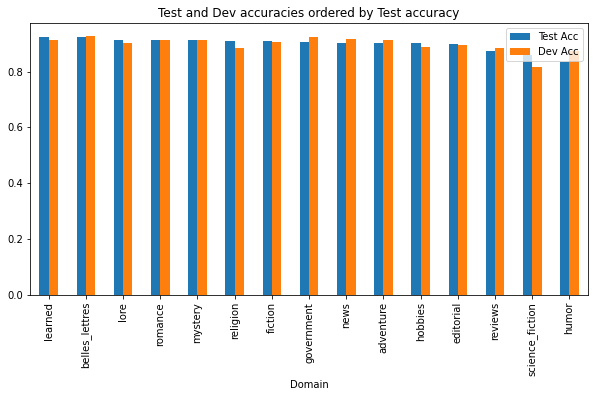

In [13]:
df.plot(x="Domain", y=["Test Acc", "Dev Acc"], kind="bar", figsize=(10, 5), title="Test and Dev accuracies ordered by Test accuracy")

In [15]:
df.sort_values(by=['Dev Acc'], ascending=False, inplace=True)
df

,Domain,Dev Acc,Test Acc,Diff Acc
1,belles_lettres,0.927163,0.923527,0.003636
4,government,0.925110,0.907244,0.017866
10,news,0.918093,0.903704,0.014388
13,romance,0.914667,0.913764,0.000903
7,learned,0.914300,0.924234,-0.009934
9,mystery,0.912859,0.911815,0.001044
0,adventure,0.911347,0.901928,0.009419
3,fiction,0.906070,0.910872,-0.004802
8,lore,0.903809,0.914473,-0.010664
2,editorial,0.896624,0.897998,-0.001374


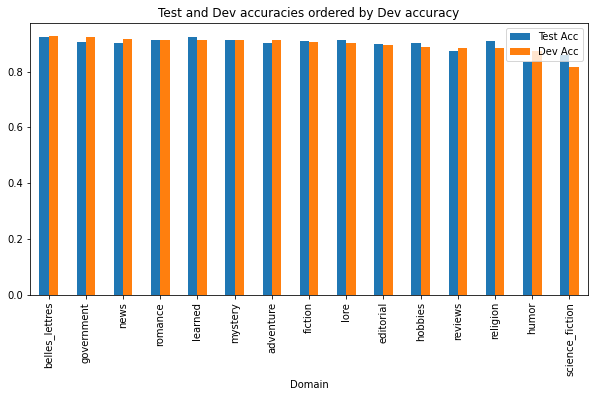

In [16]:
df.plot(x="Domain", y=["Test Acc", "Dev Acc"], kind="bar", figsize=(10, 5), title="Test and Dev accuracies ordered by Dev accuracy")

In [19]:
df.sort_values(by=['Diff Acc'], ascending=False, inplace=True)
df

,Domain,Dev Acc,Test Acc,Diff Acc
6,humor,0.873720,0.835590,0.038130
4,government,0.925110,0.907244,0.017866
10,news,0.918093,0.903704,0.014388
12,reviews,0.885701,0.872556,0.013145
0,adventure,0.911347,0.901928,0.009419
1,belles_lettres,0.927163,0.923527,0.003636
9,mystery,0.912859,0.911815,0.001044
13,romance,0.914667,0.913764,0.000903
2,editorial,0.896624,0.897998,-0.001374
3,fiction,0.906070,0.910872,-0.004802


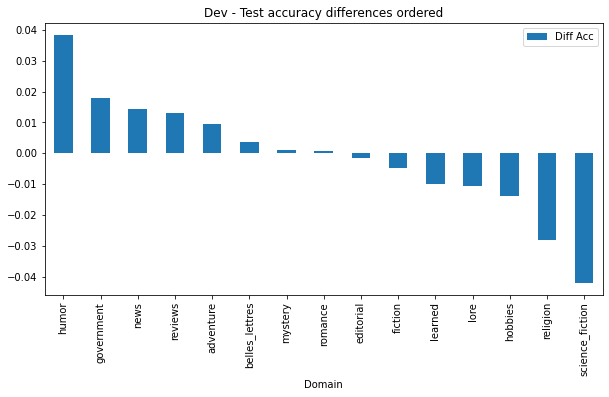

In [20]:
df.plot(x="Domain", y=["Diff Acc"], kind="bar", figsize=(10, 5), title="Dev - Test accuracy differences ordered")

## PART 2: CONFUSION MATRIX
 
Next, you will use the trigram tagger you trained for the final domain and collect the predictions on the test set using `tagger.tag_sents()`. Note that the tagger expects UNTAGGED sentences, so you will need to remove the tags from the test set. Now you will create a confusion matrix using the code from `sklearn.metrics.confusion_matrix`.
            
This function takes two arguments: 1) the true labels and 2) the predicted labels. Note that these should be flat lists containing only the tags, i.e., `test_labels = ['ADP', 'DET', 'NOUN',…]`. Therefore, you will need to manipulate both the test and predictions to get them into the correct format. Finally, use `plot_confusion_matrix()` to plot the errors.
        

1. Which labels are most often predicted correctly? Why do you think this could be?

* `CONJ`, `DET`, `NOUN`, `PRON` are predicted correctly most of the times. 

* `CONJ`, `DET`, and `PRON` are closed class categories and therefore it is easier to predict them. As there are less words, finding an unkown word is more difficult. `NOUN` is the default tag and the unkown nouns are always tagged correcly.
        
2. What are the most common errors? Why do you think this is?

* Tagging `ADJ`, `ADV` and `VERB` as `NOUN` is the most common mistake. 

* This is related to `NOUN` being the default tag. All the unkown words of thos categories will be tagged as `NOUN`. As they are open class, it is expected that there are many unkown words.

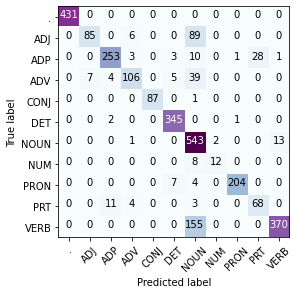

In [9]:
def plot_confusion_matrix(cm, labels, cmap=plt.cm.BuPu):
    """
    This function plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    x_tick_marks = np.arange(len(labels))
    y_tick_marks = np.arange(len(labels))
    plt.xticks(x_tick_marks, labels, rotation=45)
    plt.yticks(y_tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
# convert test to the correct data format (a flat list of tags)
test_tags = [tag for sent in test for (word, tag) in sent]

# remove the tags from the original test data and use tag_sents() to get the predictions from the final model
sents = brown.sents(categories=domain)
test_idx = int(len(sents) * .8)
test_sents = sents[test_idx:]
pred_sents = t3.tag_sents(test_sents)

# convert the predictions to the correct data format (a flat list of predicted tags)
pred_tags = [tag for sent in pred_sents for (word, tag) in sent]

# get a set of the labels (sorted(set(test)))
labels = sorted(set(test_tags))

# create the confusion matrix and plot it using the plot_confusion_matrix function
cm = confusion_matrix(test_tags, pred_tags)
plot_confusion_matrix(cm, labels)

## PART 3: VITERBI OR ERROR ANALYSIS

In this section, you will need to choose ONE of the following: a) implementing viterbi in a simple HMM-based tagger or performing in-depth error analysis on the previous results.

a) Complete the code in simple_hmm.py

b) Error analysis:

1. Based on the code already available in pos_exercise.py, create a function to find sentences with errors. Use this function to collect all the sentences with errors in the dev set of the science_fiction domain of the brown corpus.

2. Now, you will need to categorize what type of errors are found. You can use the following information to help you:
    - a) whether the word is found in the training set or not
    - b) the relative frequency of the word in the training set
    - c) the number of tags associated with the word in train
    - etc.
3. Hypothesize what phenomena might be difficult for the tagger.

### VITERBI

In [10]:
class HMM:
    """
    Q = a set of N hidden states
    A = a transition probability matrix where each a_i_j represents the probability of moving from state i to state j and np.sum(A) == 1
    O = a sequence of T observations from V
    V = a vocabulary of seen observations
    B = a sequence of emission probabilities expressing the probability of an observation o_t being generated from a state i
    PI = an initial probability distribution over states
    """

    def __init__(self, Q, V):

        self.Q = Q
        self.V = V

        # Q x Q matrix
        self.A = np.random.random((len(Q), len(Q)))
        # make sure all rows sum to 1
        self.A /= self.A.sum(1)

        # Emission probability matrix, Q x V
        self.B = np.random.random((len(V), len(Q)))
        self.B /= self.B.sum(0)

        # initial probability distribution over states, Q vector
        self.PI = np.random.random((len(Q)))

    def viterbi(self, O):
        """
        O = sequence of T observations
        This code should return an array backpointer with the
        most likely sequence through the trellis.

        e.g. O = [3, 1]
             backpointer = [0, 1]

        """

        # Set up trellis = Q x T matrix
        trellis = np.zeros((len(self.Q), len(O)))

        # set up backpointer
        backpointer = np.zeros(len(O), dtype="int")

        # compute the emission probabilaties for each beginning state
        trellis[0][0] = self.PI[0] * self.B[O[0]-1][0]
        trellis[1][0] = self.PI[1] * self.B[O[0]-1][1]
        backpointer[0] = trellis[:, 0].argmax()

        # compute forward probabilities keeping track of argmaxes with backpointer

        for t in range(1, len(O)):
            trellis[0][t] = max(trellis[:, t-1]) * self.A[backpointer[t-1]][0] * self.B[O[t]-1][0]
            trellis[1][t] = max(trellis[:, t-1]) * self.A[backpointer[t-1]][1] * self.B[O[t]-1][1]
            backpointer[t] = trellis[:, t].argmax()

        return backpointer


def main():

    """
    The example is taken from Jurafsky and Martin Ch. 8.4.

    This HMM predicts whether the day was hot or cold,
    depending on the number of icecreams that the
    author ate that day (1, 2, or 3).
    """
    label_map = {0: "hot", 1: "cold"}

    hmm = HMM(Q=["hot", "cold"], V=[1, 2, 3])

    # We set the values to those in Jurafsky and Martin
    hmm.A = np.array([[0.6, 0.4],
                      [0.5, 0.5]])

    hmm.B = np.array([[0.2, 0.5],
                      [0.4, 0.4],
                      [0.4, 0.1]])

    hmm.PI = np.array([.8, .2])

    # The observed sequence of icecream eaten we want to predict
    O = [3, 1, 3, 2, 2, 2, 2]

    labels = hmm.viterbi(O)

    print([label_map[l] for l in labels])


if __name__ == "__main__":
    main()

['hot', 'cold', 'hot', 'hot', 'hot', 'hot', 'hot']


### ERROR ANALYSIS

In [ ]:
sents = brown.sents(categories=domain)
dev_idx = int(len(sents) * .7)
test_idx = int(len(sents) * .8)
dev_sents = sents[dev_idx:test_idx]
pred_dev = t3.tag_sents(dev_sents)

for i in range(len(dev)):
    mistakes = 0
    for j in range(len(dev[i])):
        if dev[i][j] != pred_dev[i][j]:
            if mistakes == 0:
                print("Sentence", str(i) + ":", " ".join(dev_sents[i]))
            print("Mistake", str(mistakes) + ":", dev[i][j][0], dev[i][j][1], pred_dev[i][j][1])
            mistakes += 1
    if mistakes != 0:
        print()

Sentence 0: `` Don't try anything violent , Stormy .
Mistake 0: try VERB NOUN

Sentence 1: I outweigh you fifty pounds and I'm fast for a big man '' .
Mistake 0: outweigh VERB NOUN
Mistake 1: fifty NUM NOUN
Mistake 2: fast ADV ADJ

Sentence 2: `` I wasn't planning on jumping you .
Mistake 0: planning VERB NOUN
Mistake 1: jumping VERB NOUN

Sentence 3: Why do you have to jump me the first time something goes wrong ? ?
Mistake 0: jump VERB NOUN

Sentence 4: She lived and was given a name .
Mistake 0: lived VERB NOUN

Sentence 6: For her first three vegetable months she waved her crabbed claws , kicked weakly with her clubbed feet and enjoyed the usual routine of the infant .
Mistake 0: waved VERB NOUN
Mistake 1: crabbed ADJ NOUN
Mistake 2: kicked VERB NOUN
Mistake 3: weakly ADV NOUN
Mistake 4: her PRON DET
Mistake 5: clubbed VERB NOUN
Mistake 6: enjoyed VERB NOUN
Mistake 7: usual ADJ NOUN

Sentence 7: She was not alone for there were three other such children in the big city's special nu